---
title: "CART: classification"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

## a jungle party

Imagine you're throwing a party in the jungle. You know you have three types of guests—koalas, foxes, and bonobos—but you don't know who is who. To make sure you serve the right food, you need to automatically figure out which animal is which. Koalas only eat eucalyptus leaves, foxes prefer meat, and bonobos love fruit, so it's important to get it right!

To solve this problem, you'll use a decision tree. You've gathered some data on your past animal guests, and for each one, you have their height and weight, as well as their species (their label). Your goal is to build a system that can learn from this historical data to correctly classify a new, unlabeled animal based on its height and weight alone.

The data is structured as:

* **Features:** height and weight,  continuous, numerical features.
* **Categories (Classes):** Koala, Fox, Bonobo

In [1]:
#| code-summary: "import libraries"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree

We are using the famous Iris dataset structure, but pretending they are animals for this example.

In [2]:
#| code-summary: "load iris dataset and prepare data"
iris = load_iris()
X = iris.data[:, [0, 1]]
y = iris.target

/var/folders/cn/m58l7p_j6j10_4c43j4pd8gw0000gq/T/ipykernel_10048/3638754974.py:8: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X[y == i, 0], X[y == i, 1],


Text(0, 0.5, 'weight')

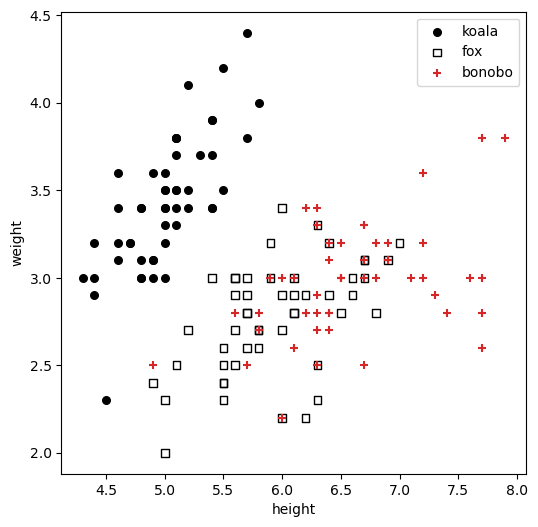

In [3]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(6, 6))
markers = ['o', 's', '+']
colors = ['black', 'None', 'tab:red']
iris.target_names = ['koala', 'fox', 'bonobo']
iris.feature_names = ['height', 'weight', 'age']
for i, marker in enumerate(markers):
    ax.scatter(X[y == i, 0], X[y == i, 1], 
               c=colors[i], 
               edgecolor='k', s=30, marker=marker, label=iris.target_names[i])
ax.legend()
ax.set_xlabel(iris.feature_names[0])
ax.set_ylabel(iris.feature_names[1])

We will use the CART (Classification and Regression Trees) algorithm to build a decision tree. There are many other methods, but CART is one of the most popular, it's important to know it well.

## the split

We will cut the data into two parts along one of the features. We will try **all possible cut thresholds** for each of the features and see which one gives us the best split. Ideally, we want to end up with two groups, "left" and "right", that are as "pure" as possible, meaning that each group contains animals of only one species. It might not be possible to get perfect homogeneity, so we will need to quantify how good a split is. We will use two different metrics to evaluate the quality of a split:

* **Information Gain (based on Entropy):** This measures how much uncertainty in the data is reduced after the split. A higher information gain means a better split.
  $$
    IG(T, X) = \underbrace{H(T)}_{\text{original entropy}} - \underbrace{\frac{N_\text{left}}{N} H(T_\text{left})}_{\text{left group}} - \underbrace{\frac{N_\text{right}}{N} H(T_\text{right})}_{\text{right group}}
  $$
  where $T_\text{left}$ and $T_\text{right}$ are the subsets after the split, and $N$ denotes the total number of samples in a (sub) dataset.

* **Gini Impurity:** This measure is often explained as the impurity of a split. A better point of view is to interpret is as the probability of misclassification. If we picked an element at random from the dataset, what is the probability that we would misclassify it if we labeled it according to the distribution of classes in the dataset? The probability of picking an element of class $i$ is $P_i$, and we would misclassify it with probability $1 - P_i$. So the total probability of misclassification is $P_i(1 - P_i)$. If we sum this over all classes, we get the Gini Impurity:
  $$
    G(T) = \sum_{i=1}^{C} P_i (1 - P_i) = 1 - \sum_{i=1}^{C} P_i^2
  $$

Now let's take our dataset and try to find the best split using both metrics.

### entropy
We will start with the **entropy** metric.


In [4]:
#| code-summary: "define useful functions" 
def calculate_gini(y_subset):
    """Calculates the Gini Impurity for a given subset of class labels."""
    # If the subset is empty, there's no impurity.
    if len(y_subset) == 0:
        return 0.0
    
    # Get the counts of each unique class in the subset.
    unique_classes, counts = np.unique(y_subset, return_counts=True)
    
    # Calculate the probability of each class.
    probabilities = counts / len(y_subset)
    
    # Gini Impurity formula: 1 - sum(p^2) for each class
    return 1.0 - np.sum(probabilities**2)

def calculate_entropy(y_subset):
    """Calculates the Entropy for a given subset of class labels."""
    if len(y_subset) == 0:
        return 0.0
    unique_classes, counts = np.unique(y_subset, return_counts=True)
    probabilities = counts / len(y_subset)
    epsilon = 1e-9
    return -np.sum(probabilities * np.log2(probabilities + epsilon))

def find_best_split(X_feature, y, criterion='entropy'):
    """
    Finds the best split point for a single feature based on a specified criterion.
    Returns the best threshold and the score (Information Gain or Gini Impurity) after the split.
    """
    # Get the unique values of the feature to consider as split points.
    unique_values = np.sort(np.unique(X_feature))
    differences = np.diff(unique_values)
    threshold_candidates = unique_values[:-1] + differences / 2
    if criterion == 'entropy':
        initial_score = calculate_entropy(y)
        best_score = 0.0  # We want to maximize Information Gain
        criterion_function = calculate_entropy
    elif criterion == 'gini':
        best_score = 1.0  # We want to minimize Gini Impurity
        criterion_function = calculate_gini
    else:
        raise ValueError("Criterion must be 'entropy' or 'gini'")

    best_threshold = None

    # Iterate through each unique value as a potential split point
    for threshold in threshold_candidates:
        # Split the data into two groups based on the threshold
        condition = X_feature <= threshold
        y_left = y[condition]    # condition is True
        y_right = y[~condition]  # condition is False

        score_left = criterion_function(y_left)
        score_right = criterion_function(y_right)
        fraction_left = len(y_left) / len(y)
        fraction_right = len(y_right) / len(y)
        weighted_score = fraction_left * score_left + fraction_right * score_right

        if criterion == 'entropy':
            information_gain = initial_score - weighted_score
            # If this split is the best so far, save it!
            if information_gain > best_score:  # Max Information Gain
                best_score = information_gain
                best_threshold = threshold
        
        elif criterion == 'gini':
            # If this split is the best so far, save it!
            if weighted_score < best_score:  # Min Gini Impurity
                best_score = weighted_score
                best_threshold = threshold

    return best_threshold, best_score

def quantify_all_splits(X_feature, y, criterion='entropy'):
    """
    Finds the best split point for a single feature based on a specified criterion.
    Returns the best threshold and the score (Information Gain or Gini Impurity) after the split.
    """
    # Get the unique values of the feature to consider as split points.
    unique_values = np.sort(np.unique(X_feature))
    differences = np.diff(unique_values)
    threshold_candidates = unique_values[:-1] + differences / 2
    score_list = []
    if criterion == 'entropy':
        initial_score = calculate_entropy(y)
        best_score = 0.0  # We want to maximize Information Gain
        criterion_function = calculate_entropy
    elif criterion == 'gini':
        best_score = 1.0  # We want to minimize Gini Impurity
        criterion_function = calculate_gini
    else:
        raise ValueError("Criterion must be 'entropy' or 'gini'")

    best_threshold = None

    # Iterate through each unique value as a potential split point
    for threshold in threshold_candidates:
        # Split the data into two groups based on the threshold
        condition = X_feature <= threshold
        y_left = y[condition]    # condition is True
        y_right = y[~condition]  # condition is False

        score_left = criterion_function(y_left)
        score_right = criterion_function(y_right)
        fraction_left = len(y_left) / len(y)
        fraction_right = len(y_right) / len(y)
        weighted_score = fraction_left * score_left + fraction_right * score_right

        if criterion == 'entropy':
            information_gain = initial_score - weighted_score
            score_list.append((threshold, information_gain))
            # If this split is the best so far, save it!

        elif criterion == 'gini':
            score_list.append((threshold, weighted_score))

    return np.array(score_list)


/var/folders/cn/m58l7p_j6j10_4c43j4pd8gw0000gq/T/ipykernel_10048/2101311549.py:11: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_main.scatter(X[y == i, 0], X[y == i, 1],
/var/folders/cn/m58l7p_j6j10_4c43j4pd8gw0000gq/T/ipykernel_10048/2101311549.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Height: highest Information Gain: 0.56 at height=5.55
Weight: highest Information Gain: 0.28 at weight=3.35


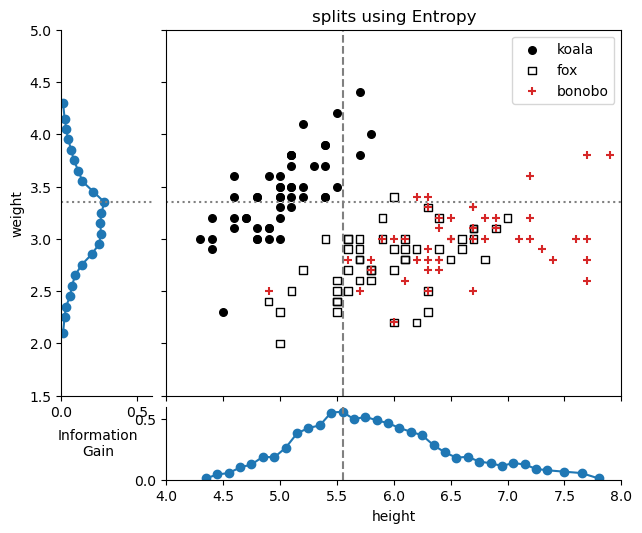

In [5]:
#| code-summary: "plot"
fig = plt.figure(1, figsize=(8, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[0.2,1], height_ratios=[1,0.2])
gs.update(left=0.16, right=0.86,top=0.88, bottom=0.13, hspace=0.05, wspace=0.05)

ax_main = plt.subplot(gs[0, 1])
ax_height = plt.subplot(gs[1, 1])
ax_weight = plt.subplot(gs[0, 0])

for i, marker in enumerate(markers):
    ax_main.scatter(X[y == i, 0], X[y == i, 1], 
                    c=colors[i], 
                    edgecolor='k', s=30, marker=marker, label=iris.target_names[i])

split_feature_height = quantify_all_splits(X[:, 0], y, criterion='entropy')
split_feature_weight = quantify_all_splits(X[:, 1], y, criterion='entropy')

ax_height.plot(split_feature_height[:, 0], split_feature_height[:, 1], marker='o')
ax_weight.plot(split_feature_weight[:, 1], split_feature_weight[:, 0], marker='o')  

best_height_split = np.argmax(split_feature_height[:, 1])
best_weight_split = np.argmax(split_feature_weight[:, 1])

ax_main.axvline(split_feature_height[best_height_split, 0], color='gray', linestyle='--')
ax_height.axvline(split_feature_height[best_height_split, 0], color='gray', linestyle='--')
ax_main.axhline(split_feature_weight[best_weight_split, 0], color='gray', linestyle=':')
ax_weight.axhline(split_feature_weight[best_weight_split, 0], color='gray', linestyle=':')

ax_main.set(xticklabels=[],
            yticklabels=[],
            title="splits using Entropy",
            xlim=(4, 8),
            ylim=(1.5, 5.0)
            )
ax_main.legend()

ax_height.set(ylim=(0, 0.6),
              xlim=(4, 8),
              xlabel="height"
              )
ax_weight.set(xlim=(0, 0.6),
              ylim=(1.5, 5.0),
                ylabel="weight",
              )

ax_weight.spines['top'].set_visible(False)
ax_weight.spines['right'].set_visible(False)
ax_height.spines['top'].set_visible(False)
ax_height.spines['right'].set_visible(False)

ax_height.text(-0.15, 0.5, "Information\nGain", rotation=0, va='center', ha='center', transform=ax_height.transAxes)
plt.tight_layout()

print(f"Height: highest Information Gain: {split_feature_height[best_height_split, 1]:.2f} at height={split_feature_height[best_height_split, 0]:.2f}")
print(f"Weight: highest Information Gain: {split_feature_weight[best_weight_split, 1]:.2f} at weight={split_feature_weight[best_weight_split, 0]:.2f}")

* The best split for the 'height' feature is at a height 5.55, with IG=0.56.
* The best split for the 'weight' feature is at a weight 3.35, with IG=0.28.

Using the Entropy metric, the first split will be on the 'height' feature at a height of 5.55, since it has the highest information gain.

### Gini impurity
Now let's try the **Gini impurity** metric.

/var/folders/cn/m58l7p_j6j10_4c43j4pd8gw0000gq/T/ipykernel_10048/3659548085.py:11: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_main.scatter(X[y == i, 0], X[y == i, 1],
/var/folders/cn/m58l7p_j6j10_4c43j4pd8gw0000gq/T/ipykernel_10048/3659548085.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Height: lowest Gini Impurity: 0.44 at height=5.45
Weight: lowest Gini Impurity: 0.54 at weight=3.35


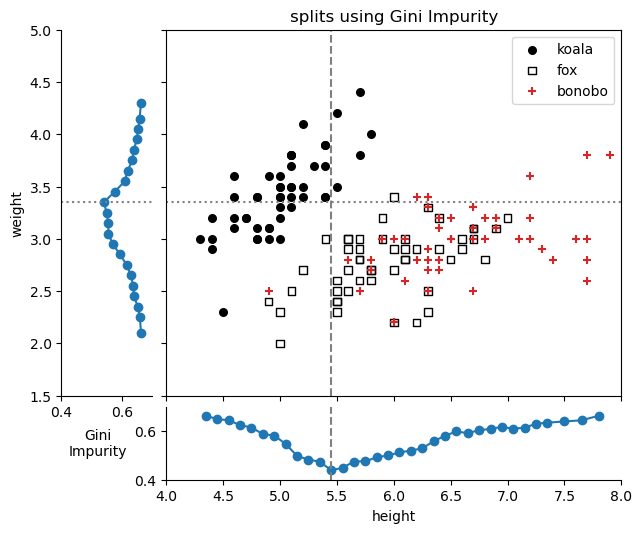

In [6]:
#| code-summary: "plot"
fig = plt.figure(1, figsize=(8, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[0.2,1], height_ratios=[1,0.2])
gs.update(left=0.16, right=0.86,top=0.88, bottom=0.13, hspace=0.05, wspace=0.05)

ax_main = plt.subplot(gs[0, 1])
ax_height = plt.subplot(gs[1, 1])
ax_weight = plt.subplot(gs[0, 0])

for i, marker in enumerate(markers):
    ax_main.scatter(X[y == i, 0], X[y == i, 1], 
                    c=colors[i], 
                    edgecolor='k', s=30, marker=marker, label=iris.target_names[i])

split_feature_height = quantify_all_splits(X[:, 0], y, criterion='gini')
split_feature_weight = quantify_all_splits(X[:, 1], y, criterion='gini')

ax_height.plot(split_feature_height[:, 0], split_feature_height[:, 1], marker='o')
ax_weight.plot(split_feature_weight[:, 1], split_feature_weight[:, 0], marker='o')  

best_height_split = np.argmin(split_feature_height[:, 1])
best_weight_split = np.argmin(split_feature_weight[:, 1])

ax_main.axvline(split_feature_height[best_height_split, 0], color='gray', linestyle='--')
ax_height.axvline(split_feature_height[best_height_split, 0], color='gray', linestyle='--')
ax_main.axhline(split_feature_weight[best_weight_split, 0], color='gray', linestyle=':')
ax_weight.axhline(split_feature_weight[best_weight_split, 0], color='gray', linestyle=':')

ax_main.set(xticklabels=[],
            yticklabels=[],
            title="splits using Gini Impurity",
            xlim=(4, 8),
            ylim=(1.5, 5.0)
            )
ax_main.legend()

ax_height.set(ylim=(0.4, 0.70),
              xlim=(4, 8),
              xlabel="height"
              )
ax_weight.set(xlim=(0.4, 0.70),
              ylim=(1.5, 5.0),
                ylabel="weight",
              )

ax_weight.spines['top'].set_visible(False)
ax_weight.spines['right'].set_visible(False)
ax_height.spines['top'].set_visible(False)
ax_height.spines['right'].set_visible(False)

ax_height.text(-0.15, 0.5, "Gini\nImpurity", rotation=0, va='center', ha='center', transform=ax_height.transAxes)
plt.tight_layout()

print(f"Height: lowest Gini Impurity: {split_feature_height[best_height_split, 1]:.2f} at height={split_feature_height[best_height_split, 0]:.2f}")
print(f"Weight: lowest Gini Impurity: {split_feature_weight[best_weight_split, 1]:.2f} at weight={split_feature_weight[best_weight_split, 0]:.2f}")

* The best split for the 'height' feature is at a height 5.45, with Gini=0.44.
* The best split for the 'weight' feature is at a weight 3.35, with Gini=0.54.

Using the Gini Impurity metric, the first split will be on the 'height' feature at a height of 5.45, since it has the lowest Gini impurity.

## successive splits

The same idea used for the first split is then applied to each of the subsets, recursively. The process continues until one of the stopping criteria is met, such as:

* All samples in a node belong to the same class.
* The maximum depth of the tree is reached.
* The number of samples in a node is less than a predefined minimum.

I find it useful to visualize the decision tree as a series of splits in the feature space:
![](decision-tree-2d.png)

Source: ["Predicting University Students’ Academic Success and Major Using Random Forests", by Cédric Beaulac and Jeffrey S. Rosenthal](https://doi.org/10.1007/s11162-019-09546-y)

Splitting the feature space with vertical and horizontal lines reminds me of a classic 1990's computer game, JazzBall. [Check out a video of the game here](https://www.youtube.com/watch?v=lKPa9ITMt-g), and see it reminds you of the basic algorithm discussed so far.


## sklearn tree DecisionTreeClassifier

We will now use the `DecisionTreeClassifier` from `sklearn.tree` to build a decision tree classifier. Let's restrict the maximum depth of the tree to 3, so we can visualize it easily. All the hard work was already coded for use, it'll take us only two lines of code to create and fit the model.



In [7]:
#| code-summary: "build and fit decision tree classifiers"
#| code-fold: show
# using gini impurity
classifier_gini = DecisionTreeClassifier(criterion='gini', max_depth=3)#, random_state=42)
classifier_gini.fit(X, y)

# using entropy
classifier_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=3)#, random_state=42)
classifier_entropy.fit(X, y)

,criterion,'entropy'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Now let's visualize the results.

In [8]:
#| code-summary: "define useful functions"
# Helper function to plot decision boundaries
def plot_decision_boundaries(ax, model, X, y, title):
    """
    Plots the decision boundaries for a given classifier.
    """
    # Define a mesh grid to color the background based on predictions
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Predict the class for each point in the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the colored regions
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)

    # Set labels and title
    ax.set_title(title)
    ax.set_xlabel(iris.feature_names[0])
    ax.set_ylabel(iris.feature_names[1])
    ax.set_xticks(())
    ax.set_yticks(())

/var/folders/cn/m58l7p_j6j10_4c43j4pd8gw0000gq/T/ipykernel_10048/759299291.py:5: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(X[y == i, 0], X[y == i, 1],
/var/folders/cn/m58l7p_j6j10_4c43j4pd8gw0000gq/T/ipykernel_10048/759299291.py:11: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[1].scatter(X[y == i, 0], X[y == i, 1],


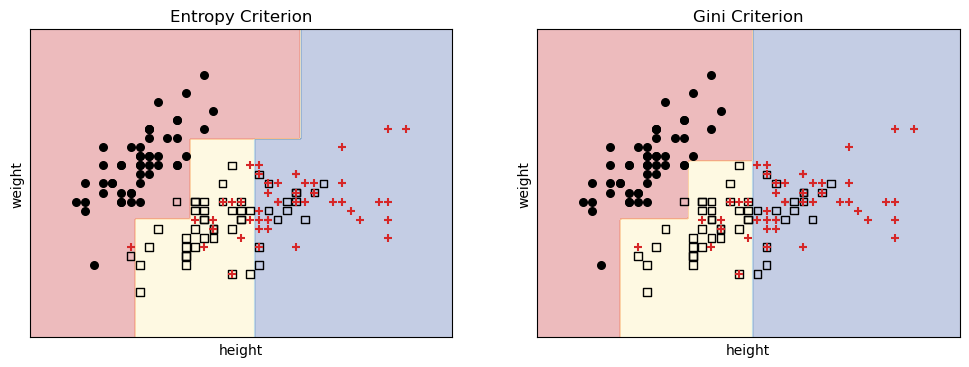

In [9]:
#| code-summary: "plot boundaries for each criterion"
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_decision_boundaries(ax[0], classifier_entropy, X, y, "Entropy Criterion")
for i, marker in enumerate(markers):
    ax[0].scatter(X[y == i, 0], X[y == i, 1], 
                  c=colors[i], 
                  edgecolor='k', s=30, marker=marker, label=iris.target_names[i])

plot_decision_boundaries(ax[1], classifier_gini, X, y, "Gini Criterion")
for i, marker in enumerate(markers):
    ax[1].scatter(X[y == i, 0], X[y == i, 1], 
                  c=colors[i], 
                  edgecolor='k', s=30, marker=marker, label=iris.target_names[i])

Just by using different criteria, we get different boundaries! We can now predict the species of a new animal based on its height and weight.

For example, an animal with height 6.3 and weight 4.0 would be classified as:

In [10]:
#| code-summary: "predict"
# Predict the species of a new animal with height 5.7 and weight 4.0 using the entropy-based classifier
sample = np.array([[6.3, 4.0]])
predicted_class_entropy = classifier_entropy.predict(sample)
predicted_class_gini = classifier_gini.predict(sample)
print(f"Predicted species (Entropy): {iris.target_names[predicted_class_entropy[0]]}")
print(f"Predicted species (Gini): {iris.target_names[predicted_class_gini   [0]]}")

Predicted species (Entropy): koala
Predicted species (Gini): bonobo


See also the decision trees for each criterion.

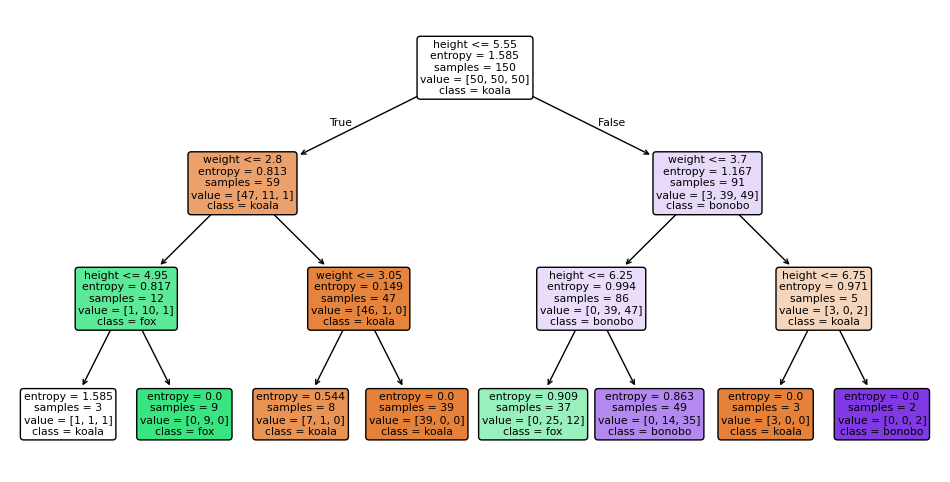

In [11]:
#| code-summary: "plot decision tree for entropy criterion"
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_tree(classifier_entropy,
          filled=True,
          rounded=True,
          class_names=iris.target_names,
          feature_names=[iris.feature_names[0], iris.feature_names[1]],
          ax=ax);

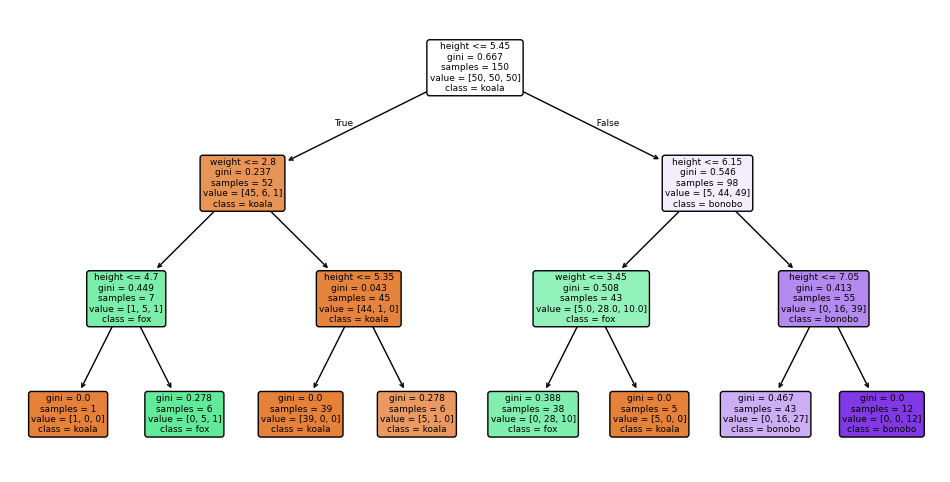

In [12]:
#| code-summary: "plot decision tree for gini criterion"
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_tree(classifier_gini,
          filled=True,
          rounded=True,
          class_names=iris.target_names,
          feature_names=[iris.feature_names[0], iris.feature_names[1]],
          ax=ax);

## overfitting

What would happen if we chose to grow our decision tree until all leaves are pure? This would lead to a very complex tree that perfectly classifies the training data, but might not generalize well to new, unseen data. This is known as overfitting.

In [13]:
#| code-summary: "no max_depth, grow until pure"
classifier_gini = DecisionTreeClassifier(criterion='gini')
classifier_gini.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


/var/folders/cn/m58l7p_j6j10_4c43j4pd8gw0000gq/T/ipykernel_10048/359429702.py:5: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(X[y == i, 0], X[y == i, 1],


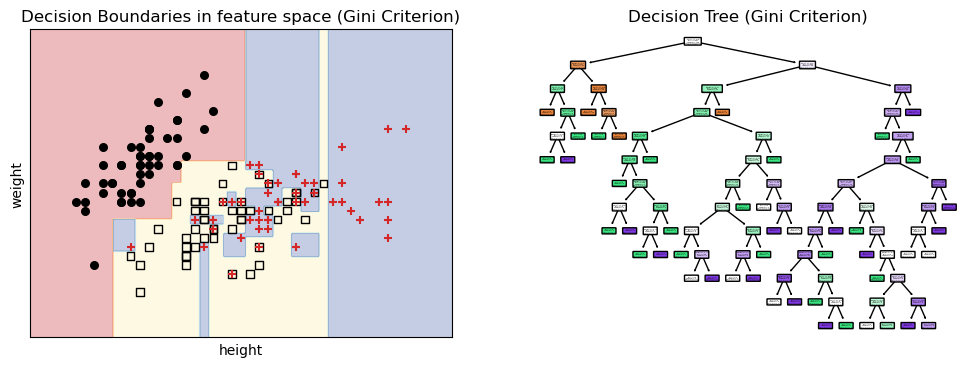

In [15]:
#| code-summary: "plot boundaries and decision tree"
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_decision_boundaries(ax[0], classifier_gini, X, y, "Decision Boundaries in feature space (Gini Criterion)")
for i, marker in enumerate(markers):
    ax[0].scatter(X[y == i, 0], X[y == i, 1], 
                  c=colors[i], 
                  edgecolor='k', s=30, marker=marker, label=iris.target_names[i])

plot_tree(classifier_gini,
          filled=True,
          rounded=True,
          class_names=iris.target_names,
          feature_names=[iris.feature_names[0], iris.feature_names[1]],
          ax=ax[1]);
ax[1].set_title("Decision Tree (Gini Criterion)");
fig.savefig("decision_boundaries_no_max_depth.png", dpi=300)

We can see that some of the regions are very small and specific to the training data points. This means that the model has learned not only the underlying patterns in the data but also the noise and outliers, which can lead to poor performance on new data.

To avoid overfitting, we can use techniques such as:

* Setting a maximum depth. We limit how deep the tree can grow. Read about `max_depth`.
* Setting a minimum number of samples required to split a node. Read about `min_samples_split`.
* Post-pruning: Cutting back the tree after it has been grown to remove branches that do not provide significant predictive power. Read about `cost_complexity_pruning_path`.

Other machine learning algorithms, such as Random Forests and Gradient Boosted Trees, use ensemble methods that combine multiple decision trees to improve performance and reduce overfitting.